In [1]:
using Gridap, Gridap.Geometry, GridapMakie, CairoMakie

## Useful helper functions

In [2]:
mean(xs) = sum(xs)/length(xs)
# In geometric terms
midpoint(xs) = mean(xs)

function plot_triangulation(trian)
    fig = plot(trian)
    wireframe!(trian, color=:black, linewidth=2);
    fig
end

function plot_FEFunction(trian, f)
    fig, _ , plt = plot(trian, f)
    Colorbar(fig[1,2], plt)
    fig
end

plot_FEFunction (generic function with 1 method)

# Problem statement
In this notebook we will study a continuous Galerkin finite element discretization of the Poisson equation
$$
\begin{align}
-\Delta u &= f\quad\text{in }\Omega\\
\end{align}
$$
where $\Omega=[0,1]^2\subset\mathbb{R}^2$. We will also construct an error estimator using Raviart-Thomas finite elements of lowest degree that will be detailed later.

In [3]:
p = 1 # Polynomial order
const int_order = p + 2 # Integration order

3

In [4]:
ncellsx = 10
ncellsy = 10
domain = (0, 1, 0, 1)
cell_nums = (ncellsx, ncellsy)
dirichlet_tags = "boundary"; # Whole boundary is Dirichlet for now, can be a subset also

### Model and triangulation
In `Gridap` terminology, the model contains a significant amount of meta-information beyond the `Triangulation`. For most purposes, the `Triangulation` is enough, but we will need other aspects of the `model` later such as the 

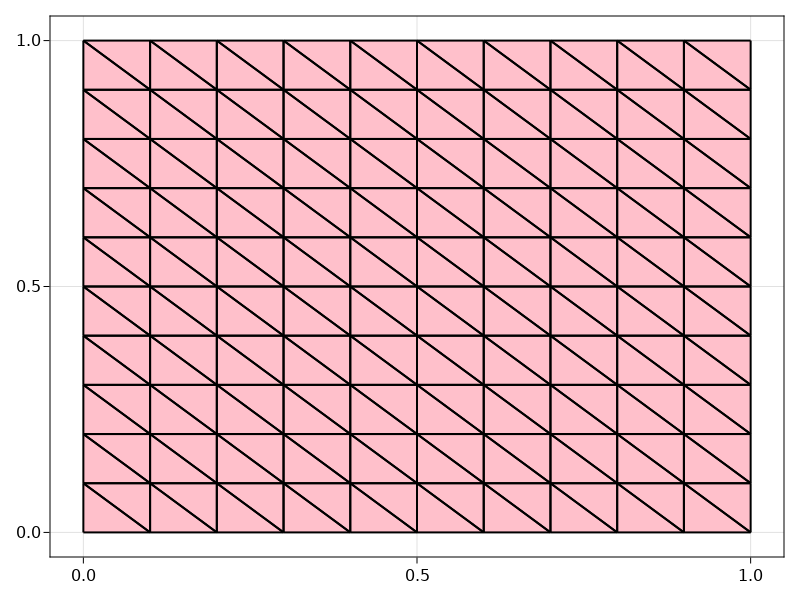

In [5]:
model = CartesianDiscreteModel(domain, cell_nums) |> simplexify
𝓣ₕ = Triangulation(model)
dx = Measure(𝓣ₕ, int_order) # For integration
plot_triangulation(𝓣ₕ);

### Manufactured solution and associated data
We consider the manufactured solution $u(x) = x(x - 1)y(y - 1)\in H_0^1(\Omega)$. The rest of the data is automatically fixed by this choice.

In [6]:
uₜ(x) = x[1] * (x[1] - 1) * x[2] * (x[2] - 1)
∇uₜ(x) = VectorValue((2 * x[1] - 1) * x[2] * (x[2] - 1), (2 * x[2] - 1) * x[1] * (x[1] - 1))
g(x) = 0.0; # Dirichlet boundary funciton. Can in general be inhomogeneous
f(x) = (-2 * (x[1] * x[1] + x[2] * x[2]) + 2 * (x[1] + x[2]));

### Manufactured solution and associated data
We consider the manufactured solution $u(x) = \sin(2\pi x)\sin(2\pi y)\in H_0^1(\Omega)$. The rest of the data is automatically fixed by this choice.

In [7]:
# uₜ(x) = sin(2π*x[1])*sin(2πx[2])
# ∇uₜ(x) = VectorValue(2π*cos(2π*x[1])*sin(2πx[2]), 2π*sin(2π*x[1])*cos(2πx[2]))
# g(x) = 0.0; # Dirichlet boundary funciton. Can in general be inhomogeneous
# f(x) = -8π^2*sin(2π*x[1])*sin(2πx[2]);

### Set up trial and test spaces

In [8]:
reffe = ReferenceFE(lagrangian, Float64, p)
V = TestFESpace(𝓣ₕ, reffe;conformity=:H1, dirichlet_tags=dirichlet_tags)
Ug = TrialFESpace(V, g);

## Weak form of the Poisson problem
We now consider the bililear form $$a(u, v) := \int_{\Omega}\nabla u\cdot\nabla v\,\mathrm{d}x$$
and the linear form $$\ell(v) := \int_\Omega f\,v\,\mathrm{d}x$$
so that the weak problem can be stated as: find $u\in V$ such that
$$a(u, v) = \ell(v),\quad\forall v\in V.$$
The existence and uniqueness of the solution is guranteed by the Lax-Milgram theorem.

In [9]:
a(u, v) = ∫(∇(u) ⋅ ∇(v))*dx
ℓ(v) = ∫(f * v)*dx;

### Solve and plot the solution

In [ ]:
op = AffineFEOperator(a, ℓ, Ug, V)
uₕ = solve(op)
plot_FEFunction(𝓣ₕ, uₕ)

# Geometric and topological data constructions
`Gridap` allows us to recover information about the underlying discretization through the `GridTopology` data structure.

In [ ]:
grid = get_grid(𝓣ₕ)
topo = Geometry.GridTopology(grid);

In [ ]:
edge_to_cells = Geometry.get_faces(topo, 1, 2)
num_edges = length(edge_to_cells)
bdry_edge_inds = findall(map(cells -> length(cells)==1, edge_to_cells))
skel_edge_inds = setdiff(1:length(edge_to_cells), bdry_edge_inds);

### Get edge lengths

In [ ]:
edge_to_nodes = Geometry.get_faces(topo, 1, 0)
node_coords = Geometry.get_node_coordinates(model)
edge_coords = [VectorValue(node_coords[nodes[1]], node_coords[nodes[2]]) for nodes in edge_to_nodes]
edge_lengths = norm.(map(x -> x[1] - x[2], edge_coords));

### Get the normal vectors
In `Gridap` terminology, the skeleton is the the interior faces only. Thus, we use the indices we just calculated to offset correctly into the `n_all` array.

In [ ]:
function get_positive_normals(trian)
    n = get_normal_vector(trian)
    edge_endpoints = get_cell_points(trian)
    n.plus(edge_endpoints)
    # plus == ⁺ is the positively oriented normal: outward on boundary and from
    # low to high GID in the interior
   midpoint.(n.plus(edge_endpoints))
end

In [ ]:
𝓢ₕ = SkeletonTriangulation(model)
𝓑ₕ = BoundaryTriangulation(model)
n_skel = get_positive_normals(𝓢ₕ)
n_bdry = get_positive_normals(𝓑ₕ)
n_all = Vector(undef, num_edges)
n_all[skel_edge_inds] = n_skel
n_all[bdry_edge_inds] = n_bdry;
#plot_triangulation(𝓢ₕ)
#plot_triangulation(𝓑ₕ)

### Evaluate the norm of the gradient
For $p=1$ e.g. Courant elements, the norm of the gradient of $u_h$ is constant on each cell. Thus, we simply evaluate at the midpoint of each cell.

In [ ]:
coords = get_cell_coordinates(𝓣ₕ)
cell_midpoints = midpoint.(coords)
∇uₕ = ∇(uₕ)
∇uₕ_at_midpoints = ∇uₕ(cell_midpoints)
plot_FEFunction(𝓣ₕ, ∇uₕ)

## Construction of the (quasi) equilibrated flux
We need to introduce some notation. Consider an arbitrary face $F\in\mathcal{E}$. For a piecewise constant function $p_h\in \mathbb{P}_0(\mathcal{T}_h)$ we define the mean value at $F$ by
$$\{p_h\}_F := 
\begin{cases}
\frac{1}{2}(p_h|_K + p_h|_{K'}), & F\in \mathcal{E}_{\mathrm{int}}\\
p_h|_K, & F\in \mathcal{E}_{\mathrm{bdry}}
\end{cases}
$$
Now that we have all the required information, the construction of the flux DOFs is easy. In effect, we want to calculate, for each edge, $F$,
$$\int_F-\{\nabla u_h\}_F\cdot n_F\,\mathrm{d}s = -|F|\{\nabla u_h\}_F\cdot n_F$$
since again we are assuing $\nabla u_h$ is piecewise constant.

In [ ]:
σ_arr = zeros(num_edges)
for edge_ind in 1:num_edges
    # Cells that share this vertex
    cell_inds = edge_to_cells[edge_ind]
    n_F = n_all[edge_ind]
    ∇uₕ_mean = mean(∇uₕ_at_midpoints[cell_inds])
    σ_arr[edge_ind] = -edge_lengths[edge_ind]*(∇uₕ_mean ⋅ n_F)  # -|F|{∇uₕ} ⋅ n_F
end

### Build the flux in Raviart-Thomas
We introduce the Raviart-Thomas space of order $k$ in dimension $d$ by
$$RT_k(\Omega) := [\mathbb{P}_k(\Omega)]^d  + \mathbb{P}_k(\Omega)x$$
We now construct the flux by populating the DOF values of a generic function in the space
For a function $\sigma\in RT_0$ the degrees of freedom are given by
$$\int_F \sigma\cdot n_F\,\mathrm{d}s$$ which are exactly the values we calculated and stored in `σ_arr`. Thus, we can directly initialize the function $\sigma \in RT_0$ with this vector of DOF values.

In [ ]:
reffe_RT₀ = ReferenceFE(raviart_thomas, Float64, 0)
RT₀ = FESpace(model, reffe_RT₀)
σ = FEFunction(RT₀, σ_arr)
plot_FEFunction(𝓣ₕ, σ)

## Error and estimator
Finally, it is time to build and evaluate the effectivity of the estimator. For the flux $\sigma$, the Prager-Synge inequality gives
$$
\|\nabla(u - u_h)\|_\Omega \le \|\nabla u + \sigma\|_\Omega
$$

In [ ]:
L²_norm(u, dΩ) = sqrt(sum( ∫( u⊙u )*dΩ ))
∇e = ∇uₕ - ∇uₜ
H¹_error = L²_norm(∇e, dx)

In [ ]:
η = L²_norm(σ + ∇uₕ, dx)
@show η
eff = η/H¹_error

### Equilibrium error
Since we do not construct $\sigma$ to exactly satisfy the equilibrium condition,

In [ ]:
L²_norm(∇⋅σ - f, dx)

## Possible vector value plots

In [ ]:
function plot_vector_field(pts, field)
    xs = map(x -> x[1], pts)
    ys = map(x -> x[2], pts)
    us = map(x -> x[1], field)
    vs = map(x -> x[2], field)
    strength = norm.(field)

    fig = Figure(resolution = (800, 800))
    Axis(fig[1, 1], backgroundcolor = "black")
    arrows!(xs, ys, us, vs, arrowsize = 10, lengthscale = 0.3,
        arrowcolor = strength, arrsize = strength, linecolor = strength)
    fig
end

In [ ]:
𝓢ₕ = SkeletonTriangulation(model)
𝓑ₕ = BoundaryTriangulation(model)
edge_coord_skel = get_cell_coordinates(𝓢ₕ)
edge_coord_bdry = get_cell_coordinates(𝓑ₕ)
edge_coord_all = Vector(undef, num_edges)
edge_coord_all[skel_edge_inds] = edge_coord_skel
edge_coord_all[bdry_edge_inds] = edge_coord_bdry
pts = midpoint.(edge_coord_all);

In [ ]:
xs = range(0, stop = 1, length = 20)
ys = xs
pts = [VectorValue(x,y) for x in xs for y in ys]
∇uₕfield = ∇uₕ.(pts)
plot_vector_field(pts, ∇uₕfield)

In [ ]:
σ_field = -σ.(pts)
plot_vector_field(pts, σ_field)